# Intro to NLP Fundamentals in TensorFlow

NLP has the goal of deriving info out of natural language (could be sequences of text/speech).

Another common term for NLP is sequence to sequence problems (seq1seq).

## Get helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions for notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-12-13 21:55:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-13 21:55:07 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get text dataset

Going to be using Kaggle's intro to NLP dataset (text samples of Tweets labeled as disaster or not disaster).

Original source: https://www.kaggle.com/c/nlp-getting-started

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# uzip data
unzip_data("nlp_getting_started.zip")


--2022-12-13 21:55:11--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2022-12-13 21:55:11 (105 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

TO visualize text samples, we have to read them in, one example is use Python: https://realpython.com/read-write-files-python/

But preference is to visualize straight away.

So another way is use Pandas...



In [3]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# what does text dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class? (disaster vs no-disaster)
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some random training examples
import random

random_index = random.randint(0, len(train_df)-5) # create random indices not higher than the total number of samples

for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster
Text:
Ginga thinks he can defeat me? Not with my L-Drago Destroy he can't!

---

Target: 0 (not real disaster
Text:
Walmart is taking steps to keep children safe in hot vehicles. Take a look at the innovative car seat here! http://t.co/z3nEvGlUFm

---

Target: 0 (not real disaster
Text:
Emergency surgery

---

Target: 0 (not real disaster
Text:
@lizbon @KidicalMassDC It's more of a structural breakdown. Or maybe a patience failure on their part.

---

Target: 1 (real disaster)
Text:
So grateful for all the support flooding in from @NetkiCorp dinner guests! THANK YOU ALL! https://t.co/ELTne5v1Qn

---



### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Use "train_test_split" for splitting training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size=.1, # use 10% of training data for validation split
    random_state=42
)

In [12]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
len(train_df_shuffled)

7613

In [14]:
# Check first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

For text problem, one of the first things is to convert text to numbers prior to building model.
* Tokenization - direct mapping of token (a token could be word or character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use default TextVectorization parameters
text_vectorizer = TextVectorization(
    max_tokens=10000, # how many words in the vocabulary (automatically add <OOV>) (out-of-vocabulary)
    # ^^ discrepancy from video, seems codebased changed... setting "max_tokens" to 10000 alternatively as opposed to "None"
    # in David's presentation
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None, # create groups of n-words? ... will treak token as on instead of grouping into n-words?
    output_mode="int", # how to map tokens to numbers
    output_sequence_length=None, # how long do we want our sequences to be?
    pad_to_max_tokens=True # pad zeros to match length? 
)

In [17]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode="int",
    output_sequence_length=max_length
)

In [19]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence]) # currently word-base tokenizing? that's why there will be 15 - 6 zeros... (padding)

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(
  f"Original text:\n {random_sentence}\
  \n\nVectorized version:"
)
text_vectorizer([random_sentence])

Original text:
 View of smoke column rising above the south end of the Blake Fire along Forest Road 1. #RouteComplex http://t.co/Yqg5Pvw5gX  

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 976,    6,  271,    1, 2001, 2204,    2,  593,  304,    6,    2,
        4087,   42, 1227,  188]])>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our trainin data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

THe parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim=max_vocab_length, # set input shape
    output_dim=128, # output shape
    embeddings_initializer="uniform",
    input_length=max_length # how long is each input
)
embedding

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(
    f"Original text:\n {random_sentence}\
    \n\nEmbedded version:"
)

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 ?#FUKUSHIMA?#TEPCO?
Mountains of debris from the Japanese tsunami have floated to the West Coast
http://t.co/y518jYrZav    

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02301893,  0.00788939, -0.04055328, ...,  0.00023852,
         -0.01486629, -0.03300257],
        [ 0.04610943,  0.00484948,  0.01495644, ...,  0.03808882,
         -0.04300601, -0.04217621],
        [-0.0192609 , -0.04483426, -0.03985146, ...,  0.04744071,
          0.00650047, -0.00860012],
        ...,
        [ 0.04129416, -0.0467351 ,  0.03286493, ...,  0.003153  ,
         -0.02076368, -0.00634911],
        [-0.00389328, -0.02602665,  0.01012271, ...,  0.04001644,
          0.04529816,  0.04110458],
        [ 0.02875146,  0.0316526 , -0.00098262, ..., -0.02057058,
         -0.02185308, -0.02196528]]], dtype=float32)>

In [25]:
# Check out a single token's ewbedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 2.30189301e-02,  7.88938999e-03, -4.05532829e-02,  3.50315496e-03,
        -4.01105769e-02, -4.61050980e-02, -2.82367598e-02, -1.33731253e-02,
        -3.48862261e-03,  1.19491592e-02,  1.28508322e-02, -1.79075971e-02,
        -3.93039957e-02,  2.41629034e-03,  1.68892182e-02,  3.03246267e-02,
        -3.16832662e-02, -9.79774073e-03,  3.30947153e-02,  4.55965437e-02,
         4.34733145e-02, -2.44963057e-02,  1.53007992e-02, -3.21492702e-02,
        -1.36238933e-02,  1.54368170e-02, -7.02570751e-03,  3.24783362e-02,
        -2.07000859e-02,  4.37226929e-02, -1.67785883e-02, -5.92496246e-03,
         3.44621204e-02, -4.73724864e-02,  4.16469686e-02,  2.29286291e-02,
         3.80797125e-02,  3.39996330e-02, -1.12097338e-03, -2.78778076e-02,
        -4.50112000e-02,  3.58708203e-05, -2.23264694e-02,  2.65025608e-02,
         3.29843909e-03,  5.67914173e-03, -4.95253578e-02,  2.86641233e-02,
        -6.96494430e-03, -2.55987793e-0

## Modelling a text dataset (running a series of experiments)
Now we've a got way to turn our text sequences into numbers,
it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.
* Model 0: Naive Bayes (baseline), this is from Sklearn ML
map: https://scikit-learn.org/stable/tutorial/
machine learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to apporach all of these?

Use the standard steps in modelling with tensorflow:
* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments
to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

**Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can
improve upon them.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modeling pipeline
model_0 = Pipeline([
  ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
  ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [28]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [29]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [30]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics everytime, however, this will be cumbersome and could

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recal
* F1-score

For a deep overview of many different evaluation methods, see the Sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [31]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)*100

  # Calculate model precision, recall and f1-score using "weighted" averages
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(
      y_true, y_pred, average="weighted"
  )
  model_results = {
      "accuracy":model_accuracy, 
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1    
  }

  return model_results

In [32]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [33]:
from helper_functions import calculate_results

### Model 1: A simple dense model


In [34]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [35]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the "number"-ized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs, so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [36]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [37]:
# Compile model
model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [38]:
# Fit the model
model_1_history = model_1.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        create_tensorboard_callback(
            dir_name=SAVE_DIR, 
            experiment_name="model_1_dense"
        )
    ]
)

Saving TensorBoard log files to: model_logs/model_1_dense/20221213-215516
Epoch 1/5
215/215 [==============================] - 4s 6ms/step - loss: 0.6100 - accuracy: 0.6946 - val_loss: 0.5385 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4411 - accuracy: 0.8168 - val_loss: 0.4696 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3458 - accuracy: 0.8628 - val_loss: 0.4559 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2836 - accuracy: 0.8918 - val_loss: 0.4639 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2368 - accuracy: 0.9104 - val_loss: 0.4840 - val_accuracy: 0.7887


In [39]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4840 - accuracy: 0.7887


[0.4839833974838257, 0.7887139320373535]

In [40]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [41]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.31295648],
       [0.7806601 ],
       [0.99754995],
       [0.12158635],
       [0.11043063],
       [0.93322206],
       [0.8982083 ],
       [0.99373525],
       [0.96753615],
       [0.28754953]], dtype=float32)

In [42]:
val_labels

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,

In [43]:
# Convert model predictions probabilities into label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [44]:
# Calculate our model_1 results
model_1_results = calculate_results(
    y_true=val_labels,
    y_pred=model_1_preds
)
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7953441303708004,
 'recall': 0.7887139107611548,
 'f1': 0.7852145092095362}

In [45]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [46]:
import numpy as np

np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [47]:
# Ge the vocab from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [48]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [49]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape # same size as vocab size and embedding dim (output_dim of our embedding layer)

(10000, 128)

In [50]:
# Every token (10000 total) is embedded in a 128 length vector

Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/tutorials/text/word_embeddings

In [51]:
embed_weights

array([[-0.02976155, -0.00057373,  0.01549847, ...,  0.02691949,
         0.02424006,  0.00562863],
       [ 0.035563  ,  0.02751039,  0.00644029, ..., -0.02746512,
        -0.01481192, -0.02885617],
       [ 0.06079359, -0.02728739,  0.05184837, ..., -0.03760158,
         0.00117812, -0.0382952 ],
       ...,
       [ 0.02674634, -0.03145319, -0.03468289, ..., -0.00572286,
         0.02749028, -0.00719532],
       [ 0.00401771, -0.02748869,  0.08246571, ..., -0.05924188,
        -0.00584458, -0.06359998],
       [ 0.07566955, -0.01653084,  0.05623515, ..., -0.01949664,
         0.08835233, -0.03654873]], dtype=float32)

In [52]:
# Creat embedding files (we got this from TensorFlow's word embeddings documentation)
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [53]:
# Download files from COlab to upload to projector 
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception: pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading the files above we can visualize them using http://projector.tensorflow.org/ and clicking the "load" button on the left hand side.

**Resources:** If you'd like to know more about embeddings, I'd encourage you to check out:
* Jay Alammar's visualized word2vec post: https://jalammar.github.io/illustrated-word2vec/
* TensorFlow's Word Embeddings guide: https://www.tensorflow.org/tutorials/text/word_embeddings

## Recurrent Neural Networks (RNNs)

RNNS are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> **Resources:** If you want an overview of the internals of a recurrent neural network , see the following:
- MIT's sequence modeling lecture: https://www.youtube.com/watch?v=qjrad0V0uJE&ab_channel=AlexanderAmini
- Chris Olah's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's the unreasonable effectiveness of recurrent neural networks: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN  typically looks like this:

`Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)`

In [54]:
# Create an LSTM model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(units=64, return_sequences=True)(x) # multiples of 8 helps speed up for GPUs (why??)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Dense(64, activation="relu")(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 15, 64)
(None, 64)
(None, 64)


In [55]:
# (None, 15, 128) embedded tokens
# (None, 15, 64) embedding shortened (cuz of LSTM?)
# (None, 64) (loses 15 dimensions, so tokens dimensions suppressed?)

In [56]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [57]:
# Compile the model
model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [58]:
# Fit the model
model_2_history = model_2.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        create_tensorboard_callback(
            dir_name=SAVE_DIR, 
            experiment_name="model_2_LSTM"
        )
    ]
)

Saving TensorBoard log files to: model_logs/model_2_LSTM/20221213-215529
Epoch 1/5
215/215 [==============================] - 8s 12ms/step - loss: 0.2193 - accuracy: 0.9247 - val_loss: 0.5194 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1621 - accuracy: 0.9416 - val_loss: 0.6509 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1317 - accuracy: 0.9527 - val_loss: 0.6595 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1102 - accuracy: 0.9575 - val_loss: 0.8145 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0849 - accuracy: 0.9658 - val_loss: 0.9869 - val_accuracy: 0.7769


In [59]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[7.2457897e-03],
       [7.9706621e-01],
       [9.9998629e-01],
       [8.4672971e-03],
       [1.3232230e-04],
       [9.9981397e-01],
       [8.6905956e-01],
       [9.9999201e-01],
       [9.9998510e-01],
       [4.0228587e-01]], dtype=float32)

In [60]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [61]:
# Calculate model 2 results
model_2_results = calculate_results(
    y_true=val_labels,
    y_pred=model_2_preds
)

model_2_results

{'accuracy': 77.69028871391076,
 'precision': 0.7784265812728361,
 'recall': 0.7769028871391076,
 'f1': 0.7750036673315875}

In [62]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [63]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# print(x.shape)
# x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of eachother
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
# x = layers.GRU(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [64]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [65]:
# Compile the model
model_3.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [66]:
# Fit the model
model_3_histroy = model_3.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        create_tensorboard_callback(
            SAVE_DIR, "model_3_GRU"
        )
    ]
)

Saving TensorBoard log files to: model_logs/model_3_GRU/20221213-215545
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1554 - accuracy: 0.9350 - val_loss: 0.6088 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0894 - accuracy: 0.9667 - val_loss: 0.7127 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0732 - accuracy: 0.9729 - val_loss: 0.8629 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0644 - accuracy: 0.9736 - val_loss: 1.0804 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0544 - accuracy: 0.9747 - val_loss: 1.0729 - val_accuracy: 0.7730


In [67]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[3.5158191e-03],
       [7.3938620e-01],
       [9.9982423e-01],
       [2.7577475e-02],
       [1.3421470e-04],
       [9.9936277e-01],
       [6.8425131e-01],
       [9.9993837e-01],
       [9.9986327e-01],
       [6.5397161e-01]], dtype=float32)

In [68]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [69]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels, y_pred=model_3_preds)

model_3_results

{'accuracy': 77.29658792650919,
 'precision': 0.775649278370019,
 'recall': 0.7729658792650919,
 'f1': 0.7704381702262061}

### Model 4: Bidirectional RNN

Normal RNNs go from left to right (just like you'd read an English Sentenc). However, a bidirectional RNN goes from right to left as well as left to right.

In [77]:
# Build a bidirectional RNN
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# ^ will double size because going in both directions...
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")



In [78]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [79]:
# Compile model
model_4.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [105]:
# Fit the model
model_4_histroy = model_4.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        create_tensorboard_callback(
            SAVE_DIR, "model_4_bidirectional"
        )
    ]
)

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20221213-222921
Epoch 1/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0348 - accuracy: 0.9822 - val_loss: 1.6607 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0373 - accuracy: 0.9816 - val_loss: 1.1864 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0400 - accuracy: 0.9793 - val_loss: 1.5386 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0360 - accuracy: 0.9825 - val_loss: 1.6683 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0326 - accuracy: 0.9842 - val_loss: 1.6811 - val_accuracy: 0.7572


In [85]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[1.17760217e-02],
       [8.06898832e-01],
       [9.99844313e-01],
       [2.37954825e-01],
       [1.39246085e-05],
       [9.99221206e-01],
       [9.40508842e-01],
       [9.99978185e-01],
       [9.99856591e-01],
       [9.95198429e-01]], dtype=float32)

In [86]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [87]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(
    y_true=val_labels,
    y_pred=model_4_preds
)

model_4_results

{'accuracy': 76.50918635170603,
 'precision': 0.7648238707003729,
 'recall': 0.7650918635170604,
 'f1': 0.7642522657439998}

In [88]:
model_3_results

{'accuracy': 77.29658792650919,
 'precision': 0.775649278370019,
 'recall': 0.7729658792650919,
 'f1': 0.7704381702262061}

## Convolution Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text is 1D.

Previously, we've used Conv2D for our image data but now we're going to use Gonv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```


### Model 5: Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D)
* Difference between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [96]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers

embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
# ^ turn target sequence into embedding
conv_1d = layers.Conv1D(
    filters=64,
    kernel_size=5, # this is also referred to as an ngram of 5 (looks at 5 words at one time)
    strides=1,
    activation="relu",
    padding="same" # default "valid" means output is smaller than input shape, and "same" means they are the same size
)

conv_1d_output = conv_1d(embedding_test) # pass thest embeding through conv1D layer
max_pool = layers.GlobalMaxPool1D() # max-pool dimensions have ot match conv dimensions (so 1D -> 1D)
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape


(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

In [97]:
# embedding_test

In [98]:
# conv_1d_output

In [99]:
# max_pool_output

In [104]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D
model_5.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_8 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_8 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 1)              

In [117]:
# Fit the model
model_5_history = model_5.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        create_tensorboard_callback(
            SAVE_DIR, "Conv1D"
        )
    ]
)

Saving TensorBoard log files to: model_logs/Conv1D/20221213-232323
Epoch 1/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0455 - accuracy: 0.9801 - val_loss: 1.3006 - val_accuracy: 0.7493
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0432 - accuracy: 0.9823 - val_loss: 1.2691 - val_accuracy: 0.7533
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0418 - accuracy: 0.9807 - val_loss: 1.3468 - val_accuracy: 0.7467
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0400 - accuracy: 0.9822 - val_loss: 1.4043 - val_accuracy: 0.7507
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0408 - accuracy: 0.9804 - val_loss: 1.2898 - val_accuracy: 0.7402


In [118]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[1.7086779e-01],
       [9.3116307e-01],
       [9.9992371e-01],
       [5.5471823e-02],
       [9.5127984e-07],
       [9.9430168e-01],
       [9.9663109e-01],
       [9.9998975e-01],
       [9.9999964e-01],
       [9.4530815e-01]], dtype=float32)

In [119]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [120]:
# Evaluate model 5 predictions
model_5_results = calculate_results(
    y_true=val_labels,
    y_pred=model_5_preds
)
model_5_results

{'accuracy': 74.01574803149606,
 'precision': 0.7396275750739656,
 'recall': 0.7401574803149606,
 'f1': 0.739377836715928}

In [121]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [111]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([
    sample_sentence,
    "When you can the universal sentence encoder on a sentence, it turns it into numbers."])


embed_samples[0][:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-0.01157028,  0.0248591 ,  0.02878048, -0.012715  ,  0.03971538,
        0.0882776 ,  0.02680984,  0.05589836, -0.0106873 , -0.00597291,
        0.00639323, -0.01819518,  0.00030813,  0.09105888,  0.05874644,
       -0.03180628,  0.01512474, -0.05162929,  0.00991367, -0.06865347,
       -0.04209306,  0.02678981,  0.03011006,  0.00321069, -0.00337973,
       -0.04787357,  0.0226672 , -0.00985925, -0.04063613, -0.01292092,
       -0.04666384,  0.05630299, -0.03949255,  0.00517686,  0.02495829,
       -0.0701444 ,  0.02871508,  0.04947684, -0.00633979, -0.08960192,
        0.02807118, -0.00808364, -0.01360602,  0.0599865 , -0.10361787,
       -0.05195374,  0.00232954, -0.02332531, -0.03758105,  0.03327728],
      dtype=float32)>

In [112]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157028,  0.0248591 ,  0.02878048, ..., -0.00186124,
         0.02315826, -0.01485021],
       [ 0.0348587 , -0.08845595, -0.01677876, ..., -0.02750706,
         0.03230235, -0.00820089]], dtype=float32)>

In [113]:
embed_samples[0].shape

TensorShape([512])

In [114]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name="USE"
)

In [134]:
# Create model using sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_6_USE")

# Compile
model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_14 (Dense)            (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [135]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        create_tensorboard_callback(
            SAVE_DIR, "tf_hub_sentence_encoder"
        )
    ]
)

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20221213-235400
Epoch 1/5
215/215 [==============================] - 4s 13ms/step - loss: 0.5119 - accuracy: 0.7888 - val_loss: 0.4519 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4153 - accuracy: 0.8165 - val_loss: 0.4384 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4025 - accuracy: 0.8189 - val_loss: 0.4330 - val_accuracy: 0.8084
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3937 - accuracy: 0.8250 - val_loss: 0.4340 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3877 - accuracy: 0.8276 - val_loss: 0.4259 - val_accuracy: 0.8150


In [136]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.16270179],
       [0.80940336],
       [0.98947537],
       [0.1991592 ],
       [0.74934965],
       [0.7426365 ],
       [0.9834372 ],
       [0.97799224],
       [0.94891596],
       [0.0905831 ]], dtype=float32)

In [137]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [138]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(
    y_true=val_labels,
    y_pred=model_6_preds
)

model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8157643862730394,
 'recall': 0.8149606299212598,
 'f1': 0.8139865765354786}

In [132]:
512/8

64.0

In [139]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [142]:
len(train_sentences), len(train_df), len(train_df_shuffled)

(6851, 7613, 7613)

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data. 

In [143]:
## Note: Making data splits like below leads to data leakage (model 7 trained on 10% data, outperforms model_6 trained on 100% of data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of the training data
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_10_percent.head(), lean(train_10_percent)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()

len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

> **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [159]:
# Making a better dataset split (No data leakage)
train_10_percent_split = int(.1*len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [158]:
train_10_percent[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [160]:
train_labels_10_percent

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,

In [161]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [163]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model you've created, you can use the `tf.keras.models.clone_model` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [165]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6) # doesn't allow for name-chaning... 
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_7_USE")


# Compile the model
model_7.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_16 (Dense)            (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [166]:
# Fit the model to the 10% training data subset
model_7_history = model_7.fit(
    train_sentences_10_percent,
    train_labels_10_percent,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        create_tensorboard_callback(
            SAVE_DIR, "tf_hub_sentence_encoder_10_percent"
        )
    ]
)

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20221214-002412
Epoch 1/5
22/22 [==============================] - 2s 43ms/step - loss: 0.6586 - accuracy: 0.7328 - val_loss: 0.6338 - val_accuracy: 0.7402
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5816 - accuracy: 0.7985 - val_loss: 0.5794 - val_accuracy: 0.7546
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5079 - accuracy: 0.8117 - val_loss: 0.5307 - val_accuracy: 0.7769
Epoch 4/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4547 - accuracy: 0.8321 - val_loss: 0.5031 - val_accuracy: 0.7848
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4175 - accuracy: 0.8409 - val_loss: 0.4904 - val_accuracy: 0.7835


In [167]:
# Make predictions on model 7
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.1862402 ],
       [0.5922674 ],
       [0.89544225],
       [0.33985412],
       [0.5719564 ],
       [0.7175587 ],
       [0.8680136 ],
       [0.7931992 ],
       [0.83478266],
       [0.12022511]], dtype=float32)

In [168]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [169]:
# Evaluate model 7 predictions
model_7_results = calculate_results(
    y_true=val_labels,
    y_pred=model_7_preds
)

model_7_results

{'accuracy': 78.34645669291339,
 'precision': 0.7843463033230456,
 'recall': 0.7834645669291339,
 'f1': 0.7820169075127241}

In [170]:
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8157643862730394,
 'recall': 0.8149606299212598,
 'f1': 0.8139865765354786}

## Comparing the performance of each of our models

In [176]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame(
    {
      "baseline": baseline_results,
      "1_simple_dense": model_1_results,
      "2_lstm": model_2_results,
      "3_gru": model_3_results,
      "4_bidirectional": model_4_results,
      "5_conv1d": model_5_results,
      "6_tf_hub_use_encoder": model_6_results,
      "7_tf_hub_use_encoder_10_percent": model_7_results
    }
)

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.871391,0.795344,0.788714,0.785215
2_lstm,77.690289,0.778427,0.776903,0.775004
3_gru,77.296588,0.775649,0.772966,0.770438
4_bidirectional,76.509186,0.764824,0.765092,0.764252
5_conv1d,74.015748,0.739628,0.740157,0.739378
6_tf_hub_use_encoder,81.496063,0.815764,0.814961,0.813987
7_tf_hub_use_encoder_10_percent,78.346457,0.784346,0.783465,0.782017


In [177]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.788714,0.795344,0.788714,0.785215
2_lstm,0.776903,0.778427,0.776903,0.775004
3_gru,0.772966,0.775649,0.772966,0.770438
4_bidirectional,0.765092,0.764824,0.765092,0.764252
5_conv1d,0.740157,0.739628,0.740157,0.739378
6_tf_hub_use_encoder,0.814961,0.815764,0.814961,0.813987
7_tf_hub_use_encoder_10_percent,0.783465,0.784346,0.783465,0.782017


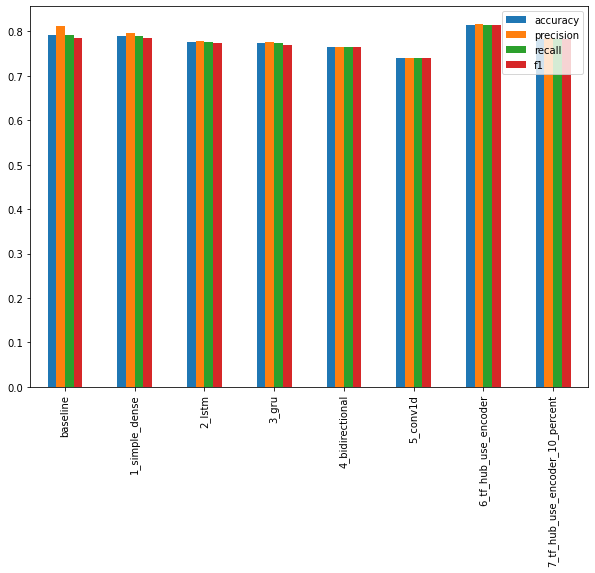

In [178]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

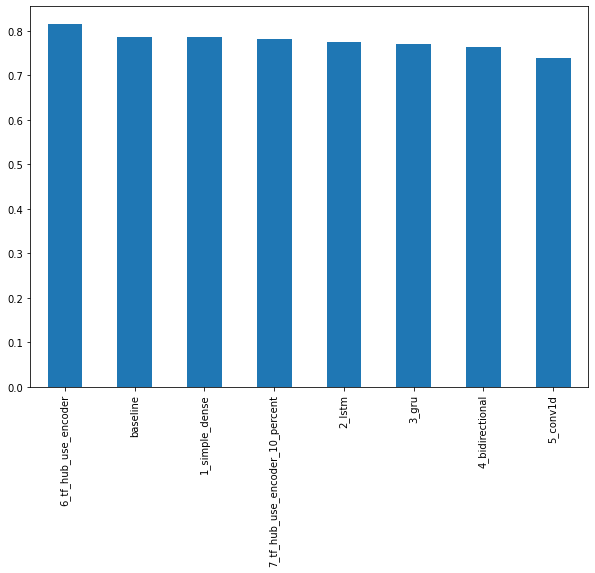

In [179]:
# Sort model results by f1-score

all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Uploading our model training logs to TensorBoard.dev

We can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [180]:
# View TensorBoard logs of transfer learning modeling experiments (plus all of our other models)
# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modeling Experiments ZTM TF Course Video" \
  --description "Comparing multiple different types of model architectures on the Kaggle" \
  --one_shot # exit the uploader once uploading is finished 


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=nBky71gTlSE7r6Z6qELae5d0EuCa6G&prompt=consent&access_type=offline

In [181]:
# See previous TensorBoard Dev experiments you've run...
!tensorboard dev list

https://tensorboard.dev/experiment/etJA0LZ2TreBRA9R82RwpA/
	Name                 NLP Modeling Experiments ZTM TF Course Video
	Description          Comparing multiple different types of model architectures on the Kaggle
	Id                   etJA0LZ2TreBRA9R82RwpA
	Created              2022-12-14 00:43:39 (2 minutes ago)
	Updated              2022-12-14 00:44:01 (2 minutes ago)
	Runs                 30
	Tags                 5
	Scalars              450
	Tensor bytes         0
	Binary object bytes  8405659
https://tensorboard.dev/experiment/ZFlUE8KiQiakv7xbCJtnLw/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   ZFlUE8KiQiakv7xbCJtnLw
	Created              2022-11-30 05:37:49
	Updated              2022-11-30 05:37:53
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary

In [ ]:
# If you need to delete an experiment from TensorBoard, you can run the following:
# !tensorboard dev delete --experiment_id etJA0LZ2TreBRA9R82RwpA

Now I've ran the cells above, my modeling experiments are visable on TensorBoard.dev: https://tensorboard.dev/experiment/etJA0LZ2TreBRA9R82RwpA/

> **Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, check out Weights & Biases: https://wandb.ai/site

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SaveModel` format (default for TensorFlow)

In [183]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [184]:
import tensorflow_hub as hub

# Load model with custom Hub Layer (required HDF5 format)
loaded_model_6 = tf.keras.models.load_model(
    "model_6.h5",
    custom_objects={"KerasLayer": hub.KerasLayer}
)

In [185]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)


24/24 [==============================] - 1s 10ms/step - loss: 0.4259 - accuracy: 0.8150


[0.4259452223777771, 0.8149606585502625]

Now let's save to the `SaveModel` format...

In [186]:
# Save TF Hub Sentence Encoder Model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [187]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [188]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4259 - accuracy: 0.8150


[0.4259451627731323, 0.8149606585502625]

In [ ]:
model_6.summary

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will predict probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0999 (really close to 1) and vice versa.

In [189]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-12-14 01:04:36--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  14.6MB/s    in 53s     

2022-12-14 01:05:30 (17.2 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.ind

In [190]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [191]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

24/24 [==============================] - 1s 9ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [194]:
# Create DataFrame with validation sentences, validation labels and best performing model predictions labels + probabilities
val_df = pd.DataFrame(
    {
        "text": val_sentences,
        "target": val_labels,
        "pred": model_6_pretrained_preds,
        "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)
    }
)

val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [195]:
# Find the wrong predictions and sort by prediction probabilities 
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [196]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [198]:
# Check the false positives (model predicted 1 when it should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544639587402
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [200]:
# Check the false negatives (model predicted 0 when it should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507579818367958
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054596975445747375
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963727295398712
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.

In [201]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## Making predictions on the test dataset 

In [202]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)

for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

1/1 [==============================] - 0s 40ms/step
Pred: 0, Prob: 0.3166169226169586
Text:
@PahandaBear @Nethaera Yup EU crashed too :P

-----

1/1 [==============================] - 0s 29ms/step
Pred: 1, Prob: 0.9592615365982056
Text:
Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/6oPYSf87K2

-----

1/1 [==============================] - 0s 29ms/step
Pred: 0, Prob: 0.05742214247584343
Text:
?? my soul just crushed because they were so damn cute ?? https://t.co/zADH87Pwml

-----

1/1 [==============================] - 0s 30ms/step
Pred: 1, Prob: 0.9903851747512817
Text:
Landslide in Italian Alps kills three: ROME (Reuters) - Three people were killed when a severe rainstorm in th... http://t.co/GX1UXeY57B

-----

1/1 [==============================] - 0s 28ms/step
Pred: 1, Prob: 0.8783754706382751
Text:
Let's appreciate that the group of people that everyone hates so much the police prevented mass casualties

## Your challenge, predicting on Tweets from the wild

Go to your favorite Twitter account and copy one of their latest Tweets.

Then pass the Tweet through our trained model.

Is that Tweet a disaster or not a disaster (according to the mode)? Is the model right or wrong?


## The speed/score tradeoff

In [203]:
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8157643862730394,
 'recall': 0.8149606299212598,
 'f1': 0.8139865765354786}

In [204]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [205]:
# Let's make a function measure the time of prediction
import time

def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """

  start_time = time.perf_counter() # get start time
  model.predict(samples)
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)

  return total_time, time_per_pred

In [206]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(
    model=model_6_pretrained, samples=val_sentences
)

model_6_total_pred_time, model_6_time_per_pred 

24/24 [==============================] - 0s 9ms/step


(0.3489933660002862, 0.0004579965433074622)

In [207]:
# Calculate baseline time per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(
    model=model_0, samples=val_sentences
)

baseline_total_pred_time, baseline_time_per_pred 

(0.026585306999550085, 3.488885433011822e-05)

In [208]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(
    y_true=val_labels,
    y_pred=model_6_pretrained_preds
)

model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

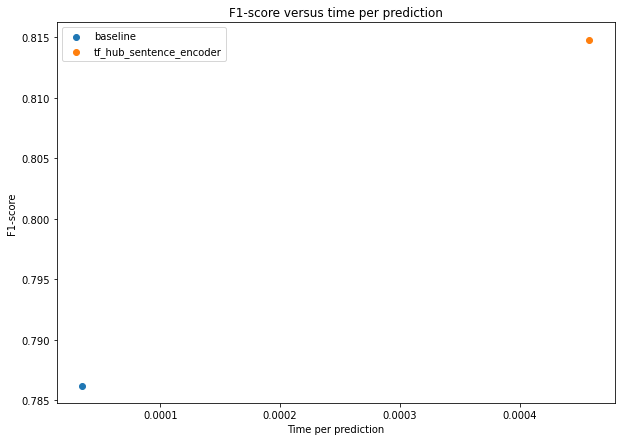

In [209]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")

plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");